<a href="https://colab.research.google.com/github/KU-Gen-AI-2567/GenerativeModelDemo/blob/main/PresentationModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.8 MB/s eta 0:00:00


In [2]:
import torch
from diffusers import StableDiffusionAdapterPipeline, T2IAdapter
import os
import kagglehub
import shutil
import pandas as pd
import numpy as np
from PIL import Image
from datasets import Dataset

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [3]:
!pwd

/content


In [4]:
# Download the dataset folder in latest version
if not "dataset" in os.listdir("."):
    path = kagglehub.dataset_download("adityajn105/flickr8k")
    print("Path to dataset files:", path)
    shutil.move(path, "./dataset")
    print("Download Dataset Complete")
else:
    print("Download Dataset Already")

100%|██████████| 1.04G/1.04G [00:10<00:00, 101MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1
Download Dataset Complete


In [5]:
df = pd.read_csv("./dataset/captions.txt")
df.rename(columns={'image':"filename"}, inplace=True)
df.loc[:1000]

,filename,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
996,124195430_d14028660f.jpg,A brown horse stands near a black horse that i...
997,124195430_d14028660f.jpg,A large brown horse stands over a small black ...
998,124195430_d14028660f.jpg,An adult horse approaching a foal on a sandy p...
999,124195430_d14028660f.jpg,A thin brown horse standing and a small black ...


In [6]:
def load_image(example):
    image_path = os.path.join("./dataset/Images", example["filename"])
    example["image"] = Image.open(image_path).convert("RGB")
    return example

dataset = Dataset.from_pandas(df.loc[:1000])
dataset = dataset.map(load_image)
dataset

Map:   0%|          | 0/1001 [00:00<?, ? examples/s]

Dataset({
    features: ['filename', 'caption', 'image'],
    num_rows: 1001
})

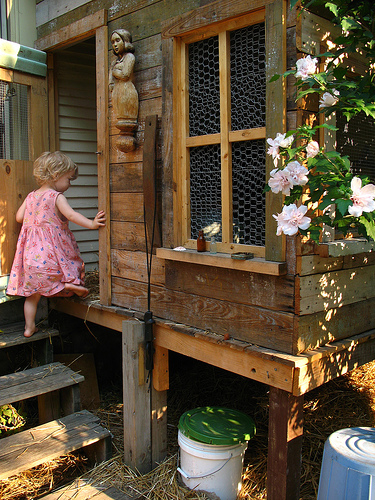

In [7]:
dataset[0]['image']

In [8]:
# preprocess
def preprocess(example):
    image = example["image"]
    image = image.resize((8, 8))
    image = image.resize((512, 512), resample=Image.Resampling.NEAREST)
    image = np.array(image)
    example["condition_images"] = Image.fromarray(image)
    return example

dataset = dataset.map(preprocess)
dataset

Map:   0%|          | 0/1001 [00:00<?, ? examples/s]

Dataset({
    features: ['filename', 'caption', 'image', 'condition_images'],
    num_rows: 1001
})

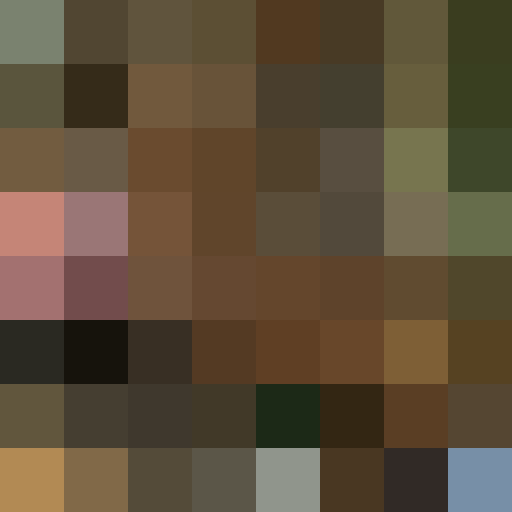

In [9]:
dataset[0]["condition_images"]

In [10]:
from torch.utils.data import DataLoader

# Define DataLoader
def collate_fn(batch):
    images = [example["image"] for example in batch]
    conditions = [example["condition_images"] for example in batch]
    texts = [example["caption"] for example in batch]
    return images, conditions, texts

dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

# Get a batch
batch = next(iter(dataloader))
print("Batch size:", len(batch[0]))

Batch size: 4


In [12]:
adapter = T2IAdapter.from_pretrained("TencentARC/t2iadapter_color_sd14v1", torch_dtype=torch.float16)
pipe = StableDiffusionAdapterPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    adapter=adapter,
    torch_dtype=torch.float16,
)
pipe.to("cuda")

print(type(pipe))

An error occurred while trying to fetch TencentARC/t2iadapter_color_sd14v1: TencentARC/t2iadapter_color_sd14v1 does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Training model

for images, conditioning_images, texts in dataloader:
    # Move data to GPU
    images = [img.to("cuda") for img in images]
    conditioning_images = [cond.to("cuda") for cond in conditioning_images]

    # Generate latents
    latents = pipe.vae.encode(images).latent_dist.sample()
    latents = latents * 0.18215  # Scale latents

    # Generate conditioning latents
    cond_latents = pipe.vae.encode(conditioning_images).latent_dist.sample()
    cond_latents = cond_latents * 0.18215

    # Compute loss (dummy example)
    noise = torch.randn_like(latents)
    noisy_latents = latents + noise
    predicted_noise = pipe.unet(noisy_latents, cond_latents).sample
    loss = ((predicted_noise - noise) ** 2).mean()

    # Backpropagation
    loss.backward()
    print("Loss:", loss.item())

In [ ]:
# generator = torch.manual_seed(0)

# out_image = pipe(
#     "Dog are attacking .",
#     image=color_palette,
#     generator=generator,
# ).images[0]
# out_image